# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 1: DATA EXPLORATION & ITEM DIAGNOSTICS
# ═══════════════════════════════════════════════════════════════════════════════

## 1.1 Environment Setup

In [50]:
import sys
import warnings
import os

# Fix for potential OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from IPython.display import display, Markdown

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

warnings.filterwarnings('ignore')

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'full'  # Using entire 511 sample for experimental analysis

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()} (N=511)")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: FULL (N=511)


## 1.2 Load Data and Metadata

In [51]:
# Load FULL sample for experimental EFA (N=511)
df_full = pd.read_csv('../data/AIRS_clean.csv')

# Load item metadata
with open('../data/airs_28item_complete.json', 'r', encoding='utf-8') as f:
    item_metadata = json.load(f)

# Extract structure - ALL items initially
ALL_PREDICTOR_ITEMS = item_metadata['predictor_items']  # 24 items
outcome_items = item_metadata['outcome_items']  # 4 BI items
ALL_CONSTRUCTS = item_metadata['constructs']
metadata = item_metadata['metadata']
positive_items = item_metadata['positive_items']
negative_items = item_metadata['negative_items']

# Create construct mapping dictionary
ALL_PREDICTOR_CONSTRUCTS = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2'],
    'HB': ['HB1', 'HB2'],
    'VO': ['VO1', 'VO2'],
    'TR': ['TR1', 'TR2'],
    'EX': ['EX1', 'EX2'],
    'ER': ['ER1', 'ER2'],
    'AX': ['AX1', 'AX2'],
}

print(f"Full sample: N = {len(df_full)}")
print(f"Total predictor items: {len(ALL_PREDICTOR_ITEMS)}")
print(f"Total constructs: {len(ALL_PREDICTOR_CONSTRUCTS)}")
print(f"\nConstructs: {list(ALL_PREDICTOR_CONSTRUCTS.keys())}")

Full sample: N = 511
Total predictor items: 24
Total constructs: 12

Constructs: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'VO', 'TR', 'EX', 'ER', 'AX']


## 1.3 Descriptive Statistics - All Items

In [52]:
# Descriptive statistics for ALL items
df_all_items = df_full[ALL_PREDICTOR_ITEMS].copy()

desc_stats = df_all_items.describe().T
desc_stats['skew'] = df_all_items.skew()
desc_stats['kurtosis'] = df_all_items.kurtosis()
desc_stats['construct'] = [metadata[item]['construct_abbr'] for item in desc_stats.index]

# Add item text for reference
desc_stats['item_text'] = [metadata[item]['question_text'][:50] + '...' for item in desc_stats.index]

print("DESCRIPTIVE STATISTICS - ALL 24 PREDICTOR ITEMS")
print("=" * 80)
display(desc_stats[['construct', 'mean', 'std', 'min', 'max', 'skew', 'kurtosis']].round(3))

# Flag potential issues
skew_issues = desc_stats[abs(desc_stats['skew']) > 1.0]
kurt_issues = desc_stats[abs(desc_stats['kurtosis']) > 3.0]

if len(skew_issues) > 0:
    print(f"\n⚠️ Items with |skewness| > 1.0: {list(skew_issues.index)}")
if len(kurt_issues) > 0:
    print(f"⚠️ Items with |kurtosis| > 3.0: {list(kurt_issues.index)}")

DESCRIPTIVE STATISTICS - ALL 24 PREDICTOR ITEMS


,construct,mean,std,min,max,skew,kurtosis
PE1,PE,3.620,1.122,1.0,5.0,-0.817,0.048
PE2,PE,3.299,1.184,1.0,5.0,-0.483,-0.625
EE1,EE,3.706,1.029,1.0,5.0,-0.679,0.069
EE2,EE,3.562,1.057,1.0,5.0,-0.683,-0.109
SI1,SI,3.074,1.176,1.0,5.0,-0.152,-0.812
SI2,SI,3.286,1.122,1.0,5.0,-0.262,-0.699
FC1,FC,3.235,1.171,1.0,5.0,-0.193,-0.987
FC2,FC,3.448,1.039,1.0,5.0,-0.651,-0.036
HM1,HM,3.268,1.193,1.0,5.0,-0.397,-0.729
HM2,HM,3.323,1.201,1.0,5.0,-0.560,-0.593


## 1.4 Item Reference Guide

Complete item text for informed selection decisions.

In [53]:
# Display full item reference
print("=" * 90)
print("COMPLETE ITEM REFERENCE GUIDE")
print("=" * 90)

for construct, items in ALL_PREDICTOR_CONSTRUCTS.items():
    construct_name = metadata[items[0]]['construct']
    print(f"\n{'─' * 90}")
    print(f"📋 {construct}: {construct_name}")
    print(f"{'─' * 90}")
    for item in items:
        direction = metadata[item]['direction']
        text = metadata[item]['question_text']
        mean_val = df_all_items[item].mean()
        std_val = df_all_items[item].std()
        print(f"  {item} [{direction:8}]: \"{text}\"")
        print(f"           Mean={mean_val:.2f}, SD={std_val:.2f}")

COMPLETE ITEM REFERENCE GUIDE

──────────────────────────────────────────────────────────────────────────────────────────
📋 PE: Performance Expectancy
──────────────────────────────────────────────────────────────────────────────────────────
  PE1 [POSITIVE]: "AI tools help me accomplish tasks more quickly."
           Mean=3.62, SD=1.12
  PE2 [POSITIVE]: "Using AI improves the quality of my work or studies."
           Mean=3.30, SD=1.18

──────────────────────────────────────────────────────────────────────────────────────────
📋 EE: Effort Expectancy
──────────────────────────────────────────────────────────────────────────────────────────
  EE1 [POSITIVE]: "Learning to use AI tools is easy for me."
           Mean=3.71, SD=1.03
  EE2 [POSITIVE]: "Interacting with AI tools is clear and understandable."
           Mean=3.56, SD=1.06

──────────────────────────────────────────────────────────────────────────────────────────
📋 SI: Social Influence
───────────────────────────────────────

## 1.5 Within-Construct Reliability Analysis

In [54]:
# Within-construct analysis functions
def cronbach_alpha(data):
    """Calculate Cronbach's alpha for a set of items."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    return (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)

def item_total_correlation(df, items):
    """Calculate corrected item-total correlations."""
    results = {}
    total = df[items].sum(axis=1)
    for item in items:
        # Corrected: exclude item from total
        corrected_total = total - df[item]
        results[item] = df[item].corr(corrected_total)
    return results

# Analyze each construct
construct_diagnostics = []

print("=" * 90)
print("WITHIN-CONSTRUCT RELIABILITY ANALYSIS - ALL CONSTRUCTS")
print("=" * 90)

for construct, items in ALL_PREDICTOR_CONSTRUCTS.items():
    construct_name = metadata[items[0]]['construct']
    construct_df = df_all_items[items]
    
    # Inter-item correlation
    r = construct_df.corr().iloc[0, 1]
    
    # Cronbach's alpha
    alpha = cronbach_alpha(construct_df)
    
    # Item-total correlations
    itc = item_total_correlation(df_all_items, items)
    
    # Status assessment
    if alpha >= 0.70:
        status = "✓ Good"
    elif alpha >= 0.60:
        status = "~ Marginal"
    else:
        status = "✗ Poor"
    
    construct_diagnostics.append({
        'Construct': construct,
        'Name': construct_name,
        'Items': ', '.join(items),
        'r_inter': r,
        'Alpha': alpha,
        'ITC_1': itc[items[0]],
        'ITC_2': itc[items[1]],
        'Status': status
    })
    
    print(f"\n{construct} ({construct_name}):")
    print(f"  Inter-item r = {r:.3f}")
    print(f"  Cronbach's α = {alpha:.3f} {status}")
    print(f"  {items[0]} ITC = {itc[items[0]]:.3f}")
    print(f"  {items[1]} ITC = {itc[items[1]]:.3f}")

diagnostics_df = pd.DataFrame(construct_diagnostics)

WITHIN-CONSTRUCT RELIABILITY ANALYSIS - ALL CONSTRUCTS

PE (Performance Expectancy):
  Inter-item r = 0.727
  Cronbach's α = 0.842 ✓ Good
  PE1 ITC = 0.727
  PE2 ITC = 0.727

EE (Effort Expectancy):
  Inter-item r = 0.722
  Cronbach's α = 0.838 ✓ Good
  EE1 ITC = 0.722
  EE2 ITC = 0.722

SI (Social Influence):
  Inter-item r = 0.632
  Cronbach's α = 0.774 ✓ Good
  SI1 ITC = 0.632
  SI2 ITC = 0.632

FC (Facilitating Conditions):
  Inter-item r = 0.640
  Cronbach's α = 0.777 ✓ Good
  FC1 ITC = 0.640
  FC2 ITC = 0.640

HM (Hedonic Motivation):
  Inter-item r = 0.793
  Cronbach's α = 0.885 ✓ Good
  HM1 ITC = 0.793
  HM2 ITC = 0.793

PV (Price Value):
  Inter-item r = 0.763
  Cronbach's α = 0.866 ✓ Good
  PV1 ITC = 0.763
  PV2 ITC = 0.763

HB (Habit):
  Inter-item r = 0.820
  Cronbach's α = 0.901 ✓ Good
  HB1 ITC = 0.820
  HB2 ITC = 0.820

VO (Voluntariness):
  Inter-item r = 0.261
  Cronbach's α = 0.409 ✗ Poor
  VO1 ITC = 0.261
  VO2 ITC = 0.261

TR (Trust in AI):
  Inter-item r = 0.831
  

In [55]:
# Summary table
print("\n" + "=" * 90)
print("CONSTRUCT RELIABILITY SUMMARY")
print("=" * 90)

display(diagnostics_df[['Construct', 'Name', 'r_inter', 'Alpha', 'ITC_1', 'ITC_2', 'Status']].round(3))

# Classification counts
good = len(diagnostics_df[diagnostics_df['Alpha'] >= 0.70])
marginal = len(diagnostics_df[(diagnostics_df['Alpha'] >= 0.60) & (diagnostics_df['Alpha'] < 0.70)])
poor = len(diagnostics_df[diagnostics_df['Alpha'] < 0.60])

print(f"\n✓ Good reliability (α ≥ .70): {good}/12 constructs")
print(f"~ Marginal reliability (.60 ≤ α < .70): {marginal}/12 constructs")
print(f"✗ Poor reliability (α < .60): {poor}/12 constructs")


CONSTRUCT RELIABILITY SUMMARY


,Construct,Name,r_inter,Alpha,ITC_1,ITC_2,Status
0,PE,Performance Expectancy,0.727,0.842,0.727,0.727,✓ Good
1,EE,Effort Expectancy,0.722,0.838,0.722,0.722,✓ Good
2,SI,Social Influence,0.632,0.774,0.632,0.632,✓ Good
3,FC,Facilitating Conditions,0.640,0.777,0.640,0.640,✓ Good
4,HM,Hedonic Motivation,0.793,0.885,0.793,0.793,✓ Good
5,PV,Price Value,0.763,0.866,0.763,0.763,✓ Good
6,HB,Habit,0.820,0.901,0.820,0.820,✓ Good
7,VO,Voluntariness,0.261,0.409,0.261,0.261,✗ Poor
8,TR,Trust in AI,0.831,0.908,0.831,0.831,✓ Good
9,EX,Explainability,0.383,0.545,0.383,0.383,✗ Poor



✓ Good reliability (α ≥ .70): 8/12 constructs
~ Marginal reliability (.60 ≤ α < .70): 0/12 constructs
✗ Poor reliability (α < .60): 4/12 constructs


## 1.6 Within-Construct Correlation Heatmap

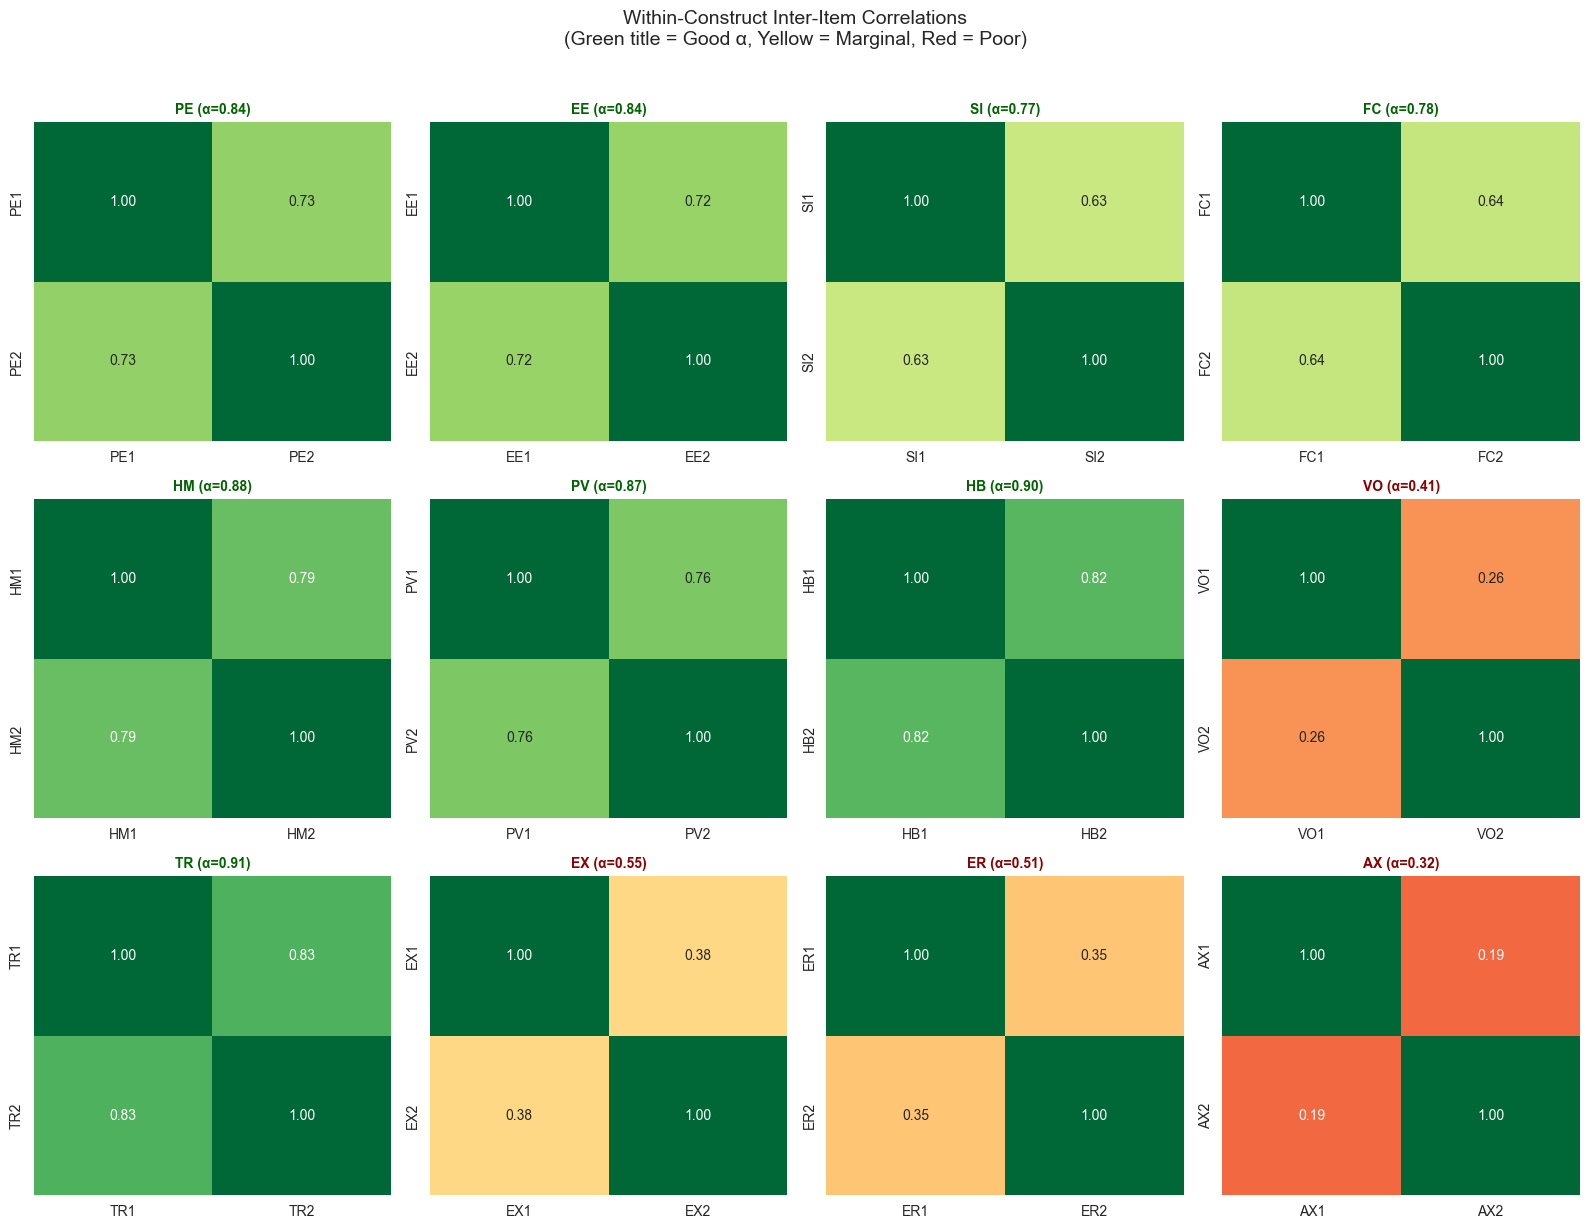

In [56]:
# Heatmap visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (construct, items) in enumerate(ALL_PREDICTOR_CONSTRUCTS.items()):
    ax = axes[idx]
    construct_df = df_all_items[items]
    corr = construct_df.corr()
    
    alpha_val = diagnostics_df[diagnostics_df['Construct'] == construct]['Alpha'].values[0]
    status = diagnostics_df[diagnostics_df['Construct'] == construct]['Status'].values[0]
    
    color = 'darkgreen' if 'Good' in status else ('goldenrod' if 'Marginal' in status else 'darkred')
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
               vmin=0, vmax=1, ax=ax, cbar=False,
               xticklabels=items, yticklabels=items)
    ax.set_title(f"{construct} (α={alpha_val:.2f})", fontsize=10, color=color, fontweight='bold')

plt.suptitle('Within-Construct Inter-Item Correlations\n(Green title = Good α, Yellow = Marginal, Red = Poor)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/phase1_within_construct_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.7 Item-Level Diagnostics Summary

In [57]:
# Create comprehensive item diagnostics
item_diagnostics = []

for item in ALL_PREDICTOR_ITEMS:
    construct = metadata[item]['construct_abbr']
    direction = metadata[item]['direction']
    
    # Find ITC from construct analysis
    construct_items = ALL_PREDICTOR_CONSTRUCTS[construct]
    itc_dict = item_total_correlation(df_all_items, construct_items)
    
    # Item stats
    mean_val = df_all_items[item].mean()
    std_val = df_all_items[item].std()
    skew_val = df_all_items[item].skew()
    kurt_val = df_all_items[item].kurtosis()
    
    # Flags
    issues = []
    if abs(skew_val) > 1.0:
        issues.append('SKEW')
    if abs(kurt_val) > 3.0:
        issues.append('KURT')
    if itc_dict[item] < 0.30:
        issues.append('LOW_ITC')
    
    item_diagnostics.append({
        'Item': item,
        'Construct': construct,
        'Direction': direction,
        'Mean': mean_val,
        'SD': std_val,
        'Skew': skew_val,
        'Kurt': kurt_val,
        'ITC': itc_dict[item],
        'Issues': ', '.join(issues) if issues else '✓'
    })

item_diag_df = pd.DataFrame(item_diagnostics)

print("=" * 90)
print("ITEM-LEVEL DIAGNOSTICS SUMMARY")
print("=" * 90)
display(item_diag_df.round(3))

# Flag problem items
problem_items = item_diag_df[item_diag_df['Issues'] != '✓']
if len(problem_items) > 0:
    print(f"\n⚠️ ITEMS WITH POTENTIAL ISSUES ({len(problem_items)}):")
    for _, row in problem_items.iterrows():
        print(f"   {row['Item']} ({row['Construct']}): {row['Issues']}")
else:
    print("\n✓ All items pass basic diagnostics")

ITEM-LEVEL DIAGNOSTICS SUMMARY


,Item,Construct,Direction,Mean,SD,Skew,Kurt,ITC,Issues
0,PE1,PE,POSITIVE,3.620,1.122,-0.817,0.048,0.727,✓
1,PE2,PE,POSITIVE,3.299,1.184,-0.483,-0.625,0.727,✓
2,EE1,EE,POSITIVE,3.706,1.029,-0.679,0.069,0.722,✓
3,EE2,EE,POSITIVE,3.562,1.057,-0.683,-0.109,0.722,✓
4,SI1,SI,POSITIVE,3.074,1.176,-0.152,-0.812,0.632,✓
5,SI2,SI,POSITIVE,3.286,1.122,-0.262,-0.699,0.632,✓
6,FC1,FC,POSITIVE,3.235,1.171,-0.193,-0.987,0.640,✓
7,FC2,FC,POSITIVE,3.448,1.039,-0.651,-0.036,0.640,✓
8,HM1,HM,POSITIVE,3.268,1.193,-0.397,-0.729,0.793,✓
9,HM2,HM,POSITIVE,3.323,1.201,-0.560,-0.593,0.793,✓



⚠️ ITEMS WITH POTENTIAL ISSUES (4):
   VO1 (VO): LOW_ITC
   VO2 (VO): LOW_ITC
   AX1 (AX): LOW_ITC
   AX2 (AX): LOW_ITC


## 1.8 KMO and Bartlett's Test (All Items)

In [58]:
# KMO and Bartlett's on ALL items
kmo_all, kmo_model = calculate_kmo(df_all_items)
chi_square, p_value = calculate_bartlett_sphericity(df_all_items)

print("=" * 90)
print("FACTORABILITY ASSESSMENT - ALL 24 ITEMS")
print("=" * 90)

print(f"\nKMO Measure of Sampling Adequacy: {kmo_model:.3f}")
if kmo_model >= 0.90:
    kmo_interpretation = "Marvelous"
elif kmo_model >= 0.80:
    kmo_interpretation = "Meritorious"
elif kmo_model >= 0.70:
    kmo_interpretation = "Middling"
elif kmo_model >= 0.60:
    kmo_interpretation = "Mediocre"
elif kmo_model >= 0.50:
    kmo_interpretation = "Miserable"
else:
    kmo_interpretation = "Unacceptable"
print(f"  Interpretation: {kmo_interpretation} (Kaiser, 1974)")

print(f"\nBartlett's Test of Sphericity:")
print(f"  Chi-square: {chi_square:.2f}")
print(f"  p-value: {p_value:.2e}")
print(f"  Result: {'✓ Significant' if p_value < 0.001 else '✗ Not significant'}")

# Item-level KMO
print(f"\nItem-level KMO (flagged if < 0.50):")
low_kmo_items = [(ALL_PREDICTOR_ITEMS[i], kmo_all[i]) for i in range(len(ALL_PREDICTOR_ITEMS)) if kmo_all[i] < 0.50]
if low_kmo_items:
    for item, kmo in low_kmo_items:
        print(f"  ⚠️ {item}: {kmo:.3f}")
else:
    print("  ✓ All items have KMO ≥ 0.50")

FACTORABILITY ASSESSMENT - ALL 24 ITEMS

KMO Measure of Sampling Adequacy: 0.948
  Interpretation: Marvelous (Kaiser, 1974)

Bartlett's Test of Sphericity:
  Chi-square: 8589.47
  p-value: 0.00e+00
  Result: ✓ Significant

Item-level KMO (flagged if < 0.50):
  ✓ All items have KMO ≥ 0.50


# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 DECISION POINT 1: SELECT CONSTRUCTS AND ITEMS
# ═══════════════════════════════════════════════════════════════════════════════

Based on the diagnostics above, decide which items to include in the EFA.

**Considerations:**
- Constructs with poor reliability (α < .60) may not hold together
- Items with low ITC (< .30) may not contribute to their construct
- Items with extreme skewness or kurtosis may cause issues
- Theoretical relevance to your population

**Edit the `SELECTED_ITEMS` dictionary below to customize your selection.**

In [59]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  🎯 DECISION POINT 1: EDIT THIS DICTIONARY TO SELECT ITEMS                   ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

# ═══════════════════════════════════════════════════════════════════════════════
# ITEM REFERENCE (for cherry-picking decisions)
# ═══════════════════════════════════════════════════════════════════════════════
# PE - Performance Expectancy (POSITIVE)
#   PE1: "AI tools help me accomplish tasks more quickly."
#   PE2: "Using AI improves the quality of my work or studies."
#
# EE - Effort Expectancy (POSITIVE)
#   EE1: "Learning to use AI tools is easy for me."
#   EE2: "Interacting with AI tools is clear and understandable."
#
# SI - Social Influence (POSITIVE)
#   SI1: "People whose opinions I value encourage me to use AI tools."
#   SI2: "Leaders in my organization or school support the use of AI tools."
#
# FC - Facilitating Conditions (POSITIVE)
#   FC1: "I have access to training or tutorials for the AI tools I use."
#   FC2: "The AI tools I use are compatible with other tools or systems I use."
#
# HM - Hedonic Motivation (POSITIVE)
#   HM1: "Using AI tools is stimulating and engaging."
#   HM2: "AI tools make my work or studies more interesting."
#
# PV - Price Value (POSITIVE)
#   PV1: "I get more value from AI tools than the effort they require."
#   PV2: "Using AI tools is worth the learning curve."
#
# HB - Habit (POSITIVE)
#   HB1: "Using AI tools has become a habit for me."
#   HB2: "I tend to rely on AI tools by default when I need help with tasks."
#
# VO - Voluntariness (POSITIVE)
#   VO1: "I choose to use AI tools in my work because I find them helpful, not because I am required to."
#   VO2: "I could choose not to use AI tools in my work or studies if I preferred."
#
# TR - Trust in AI (POSITIVE)
#   TR1: "I trust AI tools to provide reliable information."
#   TR2: "I trust the AI tools that are available to me."
#
# EX - Explainability (POSITIVE)
#   EX1: "I understand how the AI tools I use generate their outputs."
#   EX2: "I prefer AI tools that explain their recommendations."
#
# ER - Perceived Ethical Risk (NEGATIVE)
#   ER1: "I worry that AI tools could replace jobs in my field."
#   ER2: "I am concerned about privacy risks when using AI tools."
#
# AX - AI Anxiety (MIXED)
#   AX1: "I feel uneasy about the increasing use of AI." (NEGATIVE)
#   AX2: "I worry that I may be left behind if I do not keep up with AI." (POSITIVE - FOMO)
# ═══════════════════════════════════════════════════════════════════════════════

SELECTED_ITEMS = {
    'PE': ['PE1', 'PE2'],  # Performance Expectancy
    'EE': ['EE1', 'EE2'],  # Effort Expectancy
    'SI': ['SI1', 'SI2'],  # Social Influence
    'FC': ['FC1', 'FC2'],  # Facilitating Conditions
    'HM': ['HM1', 'HM2'],  # Hedonic Motivation
    'PV': ['PV1', 'PV2'],  # Price Value
    'HB': ['HB1', 'HB2'],  # Habit
    'VO': ['VO1', 'VO2'],  # Voluntariness
    'TR': ['TR1', 'TR2'],  # Trust in AI
    'EX': ['EX1', 'EX2'],  # Explainability
    'ER': ['ER1', 'ER2'],  # Perceived Ethical Risk (NEGATIVE)
    'AX': ['AX1', 'AX2'],  # AI Anxiety (MIXED direction)
}

# ═══════════════════════════════════════════════════════════════════════════════
# Apply selection and update working variables
# ═══════════════════════════════════════════════════════════════════════════════

selected_predictor_items = [item for items in SELECTED_ITEMS.values() for item in items]
selected_predictor_constructs = {k: v for k, v in SELECTED_ITEMS.items() if v}

# Create EFA dataframe with selected items
df_efa = df_full[selected_predictor_items].copy()

# Update global references
predictor_items = selected_predictor_items
predictor_constructs = selected_predictor_constructs

# Summary
total_selected = len(predictor_items)
constructs_active = len([k for k, v in SELECTED_ITEMS.items() if v])
constructs_full = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 2])
constructs_partial = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 1])
constructs_dropped = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 0])

print("=" * 90)
print("🎯 DECISION POINT 1 - ITEM SELECTION APPLIED")
print("=" * 90)
print(f"\n📊 Selection Summary:")
print(f"   Total items selected: {total_selected}/24")
print(f"   Active constructs: {constructs_active}/12")
print(f"     - Full (2 items): {constructs_full}")
print(f"     - Partial (1 item): {constructs_partial}")
print(f"     - Dropped (0 items): {constructs_dropped}")

print(f"\n📋 Selected Items by Construct:")
for construct, items in SELECTED_ITEMS.items():
    if items:
        print(f"   {construct}: {', '.join(items)}")
    else:
        print(f"   {construct}: [DROPPED]")

print(f"\n✓ df_efa ready: {df_efa.shape[0]} observations × {df_efa.shape[1]} items")

🎯 DECISION POINT 1 - ITEM SELECTION APPLIED

📊 Selection Summary:
   Total items selected: 24/24
   Active constructs: 12/12
     - Full (2 items): 12
     - Partial (1 item): 0
     - Dropped (0 items): 0

📋 Selected Items by Construct:
   PE: PE1, PE2
   EE: EE1, EE2
   SI: SI1, SI2
   FC: FC1, FC2
   HM: HM1, HM2
   PV: PV1, PV2
   HB: HB1, HB2
   VO: VO1, VO2
   TR: TR1, TR2
   EX: EX1, EX2
   ER: ER1, ER2
   AX: AX1, AX2

✓ df_efa ready: 511 observations × 24 items


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 2: FACTOR EXPLORATION
# ═══════════════════════════════════════════════════════════════════════════════

## 2.1 Parallel Analysis & Kaiser Criterion

In [60]:
# Eigenvalue analysis
fa_eigen = FactorAnalyzer(rotation=None, n_factors=len(predictor_items))
fa_eigen.fit(df_efa)
ev, v = fa_eigen.get_eigenvalues()

# Parallel analysis
from factor_analyzer.factor_analyzer import calculate_kmo

def parallel_analysis(data, n_iterations=100, percentile=95):
    """Perform parallel analysis to determine number of factors."""
    n_obs, n_vars = data.shape
    random_eigenvalues = np.zeros((n_iterations, n_vars))
    
    for i in range(n_iterations):
        random_data = np.random.normal(size=(n_obs, n_vars))
        random_corr = np.corrcoef(random_data, rowvar=False)
        random_eigenvalues[i] = np.linalg.eigvalsh(random_corr)[::-1]
    
    return np.percentile(random_eigenvalues, percentile, axis=0)

random_ev = parallel_analysis(df_efa.values)

# Determine factors by different criteria
n_factors_kaiser = sum(ev > 1)
n_factors_pa = sum(ev > random_ev)

print("=" * 90)
print("FACTOR EXTRACTION CRITERIA")
print("=" * 90)

print(f"\n{'Factor':<8} {'Eigenvalue':<12} {'Random EV':<12} {'Kaiser':<10} {'PA':<10}")
print("-" * 60)
for i in range(min(12, len(ev))):
    kaiser = "✓" if ev[i] > 1 else ""
    pa = "✓" if ev[i] > random_ev[i] else ""
    print(f"F{i+1:<7} {ev[i]:<12.3f} {random_ev[i]:<12.3f} {kaiser:<10} {pa:<10}")

print(f"\n📊 Recommendations:")
print(f"   Kaiser criterion (λ > 1): {n_factors_kaiser} factors")
print(f"   Parallel analysis: {n_factors_pa} factors")

FACTOR EXTRACTION CRITERIA

Factor   Eigenvalue   Random EV    Kaiser     PA        
------------------------------------------------------------
F1       11.406       1.469        ✓          ✓         
F2       2.006        1.391        ✓          ✓         
F3       1.452        1.331        ✓          ✓         
F4       1.058        1.286        ✓                    
F5       0.830        1.249                             
F6       0.711        1.211                             
F7       0.674        1.174                             
F8       0.601        1.143                             
F9       0.595        1.110                             
F10      0.538        1.083                             
F11      0.491        1.056                             
F12      0.476        1.024                             

📊 Recommendations:
   Kaiser criterion (λ > 1): 4 factors
   Parallel analysis: 3 factors


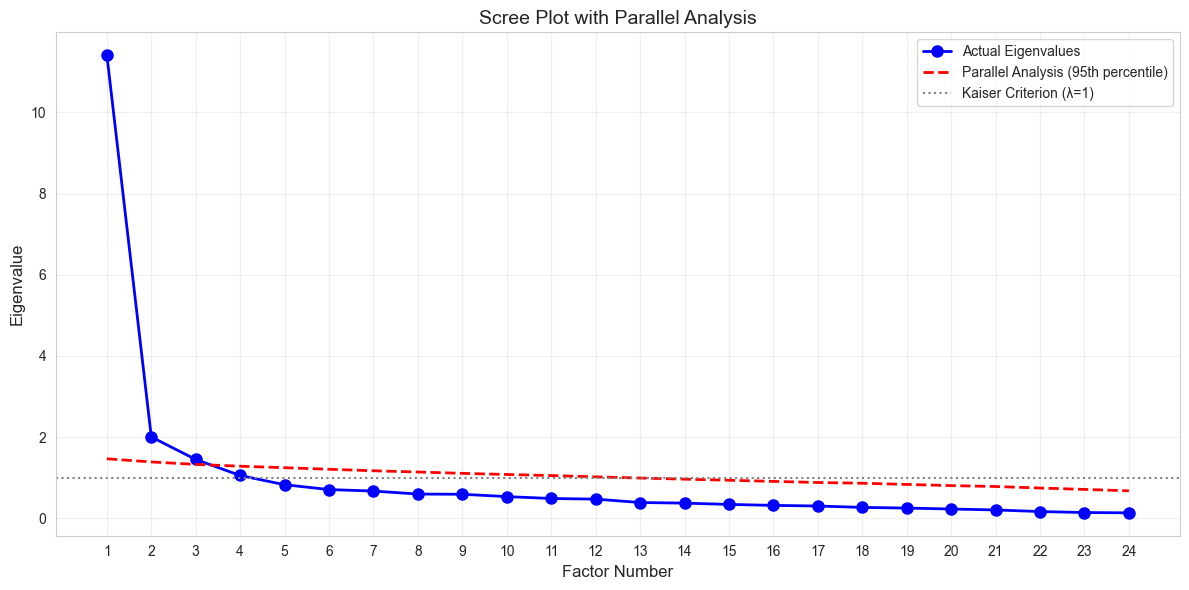

✓ Scree plot saved


In [61]:
# Scree plot with parallel analysis
fig, ax = plt.subplots(figsize=(12, 6))

x = range(1, len(ev) + 1)
ax.plot(x, ev, 'bo-', linewidth=2, markersize=8, label='Actual Eigenvalues')
ax.plot(x, random_ev, 'r--', linewidth=2, label='Parallel Analysis (95th percentile)')
ax.axhline(y=1, color='gray', linestyle=':', label='Kaiser Criterion (λ=1)')

ax.set_xlabel('Factor Number', fontsize=12)
ax.set_ylabel('Eigenvalue', fontsize=12)
ax.set_title('Scree Plot with Parallel Analysis', fontsize=14)
ax.legend()
ax.set_xticks(range(1, len(ev) + 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/phase2_scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Scree plot saved")

## 2.2 Full Factor Solution (All Possible Factors)

Exploring ALL factors to identify which have meaningful loadings, regardless of eigenvalue.

In [62]:
# Fit maximum factors (up to 12 or number of items)
n_factors_max = min(12, len(predictor_items))

print(f"Fitting EFA with {n_factors_max} factors (maximum exploration)")
print(f"  Estimator: MINRES")
print(f"  Rotation: Promax (oblique)")

efa_full = FactorAnalyzer(n_factors=n_factors_max, rotation='promax', method='minres')
efa_full.fit(df_efa)

# Get variance explained
var_full = efa_full.get_factor_variance()
eigenvalues_full = var_full[0]
prop_var_full = var_full[1]
cum_var_full = var_full[2]

print(f"\n{'Factor':<8} {'SS Loading':<12} {'% Variance':<12} {'Cumulative %':<12} {'Strength':<15}")
print("-" * 70)
for i in range(n_factors_max):
    if eigenvalues_full[i] >= 1.0:
        strength = "★★★ Strong"
    elif eigenvalues_full[i] >= 0.5:
        strength = "★★ Moderate"
    elif eigenvalues_full[i] >= 0.3:
        strength = "★ Weak"
    else:
        strength = "✗ Minimal"
    print(f"F{i+1:<7} {eigenvalues_full[i]:<12.3f} {prop_var_full[i]*100:<12.1f} {cum_var_full[i]*100:<12.1f} {strength}")

print(f"\nTotal variance explained: {cum_var_full[-1]*100:.1f}%")

Fitting EFA with 12 factors (maximum exploration)
  Estimator: MINRES
  Rotation: Promax (oblique)

Factor   SS Loading   % Variance   Cumulative % Strength       
----------------------------------------------------------------------
F1       6.194        25.8         25.8         ★★★ Strong
F2       1.643        6.8          32.7         ★★★ Strong
F3       1.448        6.0          38.7         ★★★ Strong
F4       1.263        5.3          43.9         ★★★ Strong
F5       1.102        4.6          48.5         ★★★ Strong
F6       1.006        4.2          52.7         ★★★ Strong
F7       0.982        4.1          56.8         ★★ Moderate
F8       0.970        4.0          60.9         ★★ Moderate
F9       0.910        3.8          64.7         ★★ Moderate
F10      0.730        3.0          67.7         ★★ Moderate
F11      0.524        2.2          69.9         ★★ Moderate
F12      0.367        1.5          71.4         ★ Weak

Total variance explained: 71.4%


## 2.3 Full Pattern Matrix

In [63]:
# Pattern matrix
loadings_full = pd.DataFrame(
    efa_full.loadings_,
    index=predictor_items,
    columns=[f'F{i+1}' for i in range(n_factors_max)]
)

# Add construct labels
loadings_full['Construct'] = [metadata[item]['construct_abbr'] for item in loadings_full.index]

# Highlighting function
def highlight_loadings(val):
    if abs(val) >= 0.50:
        return 'background-color: darkgreen; color: white; font-weight: bold'
    elif abs(val) >= 0.32:
        return 'background-color: goldenrod; color: white'
    return ''

print("FULL PATTERN MATRIX")
print("Green ≥ 0.50 (strong), Yellow ≥ 0.32 (moderate)")
print("=" * 90)

factor_cols = [f'F{i+1}' for i in range(n_factors_max)]
styled = loadings_full[factor_cols + ['Construct']].style.applymap(
    highlight_loadings, subset=factor_cols
).format('{:.3f}', subset=factor_cols)
display(styled)

FULL PATTERN MATRIX
Green ≥ 0.50 (strong), Yellow ≥ 0.32 (moderate)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,Construct
PE1,0.692,0.164,0.015,0.068,-0.019,0.069,-0.009,-0.170,0.026,0.010,-0.101,0.143,PE
PE2,0.755,-0.030,-0.006,-0.011,0.029,0.066,-0.010,-0.006,0.010,-0.186,-0.044,0.556,PE
EE1,-0.015,1.153,-0.052,0.042,-0.015,-0.025,-0.015,-0.075,-0.039,-0.028,0.017,-0.028,EE
EE2,0.081,0.500,0.049,-0.090,0.019,-0.036,0.025,0.155,0.047,0.091,0.023,0.017,EE
SI1,0.365,0.053,0.018,-0.067,-0.065,0.634,0.077,-0.078,0.044,0.011,0.140,-0.033,SI
SI2,0.080,-0.063,-0.033,0.011,0.010,0.714,-0.017,0.054,-0.043,0.092,-0.087,0.045,SI
FC1,-0.130,0.057,0.432,0.108,0.039,0.211,-0.045,0.220,0.031,-0.067,-0.052,-0.008,FC
FC2,0.097,-0.041,1.104,-0.074,-0.050,-0.051,0.020,-0.151,-0.013,0.037,0.064,-0.004,FC
HM1,1.116,0.041,0.070,0.056,0.007,-0.036,-0.020,0.088,-0.066,-0.086,0.569,-0.052,HM
HM2,0.977,-0.087,0.022,0.011,0.057,-0.029,-0.010,0.062,0.042,-0.012,0.300,0.122,HM


## 2.4 Factor Quality Assessment

In [64]:
# Analyze each factor's quality
print("=" * 90)
print("FACTOR QUALITY ANALYSIS (by loading strength)")
print("=" * 90)

factor_quality = []

for i in range(n_factors_max):
    factor_name = f'F{i+1}'
    factor_loadings = loadings_full[factor_name]
    abs_loadings = factor_loadings.abs()
    
    # Count items by loading strength
    strong_items = loadings_full[abs_loadings >= 0.50].index.tolist()
    moderate_items = loadings_full[(abs_loadings >= 0.32) & (abs_loadings < 0.50)].index.tolist()
    
    # Check cross-loading issues
    cross_loading_issues = []
    for item in strong_items:
        other_factors = [f'F{j+1}' for j in range(n_factors_max) if j != i]
        other_loadings = loadings_full.loc[item, other_factors].abs()
        if other_loadings.max() >= 0.32:
            cross_factor = other_loadings.idxmax()
            cross_loading_issues.append(f"{item}→{cross_factor}")
    
    # Get constructs loading on this factor
    constructs = [metadata[item]['construct_abbr'] for item in strong_items]
    unique_constructs = list(set(constructs))
    
    # Quality rating
    if len(strong_items) >= 2 and len(cross_loading_issues) == 0:
        quality = "★★★ RETAIN (clean, multi-item)"
    elif len(strong_items) >= 2:
        quality = "★★ RETAIN (minor cross-loading)"
    elif len(strong_items) == 1 and len(cross_loading_issues) == 0:
        quality = "★ CONSIDER (single-item, clean)"
    else:
        quality = "✗ SKIP"
    
    factor_quality.append({
        'Factor': factor_name,
        'Eigenvalue': eigenvalues_full[i],
        'Strong_Items': len(strong_items),
        'Cross_Loadings': len(cross_loading_issues),
        'Constructs': unique_constructs,
        'Quality': quality
    })
    
    print(f"\n{factor_name} (λ={eigenvalues_full[i]:.2f}): {quality}")
    if strong_items:
        print(f"   Strong items: {', '.join(strong_items)}")
        print(f"   Constructs: {', '.join(unique_constructs)}")
    if cross_loading_issues:
        print(f"   ⚠️ Cross-loadings: {', '.join(cross_loading_issues)}")

quality_df = pd.DataFrame(factor_quality)

FACTOR QUALITY ANALYSIS (by loading strength)

F1 (λ=6.19): ★★ RETAIN (minor cross-loading)
   Strong items: PE1, PE2, HM1, HM2, PV1, PV2, VO1
   Constructs: HM, VO, PV, PE
   ⚠️ Cross-loadings: PE2→F12, HM1→F11

F2 (λ=1.64): ★ CONSIDER (single-item, clean)
   Strong items: EE1
   Constructs: EE

F3 (λ=1.45): ★ CONSIDER (single-item, clean)
   Strong items: FC2
   Constructs: FC

F4 (λ=1.26): ★★★ RETAIN (clean, multi-item)
   Strong items: ER1, ER2, AX1
   Constructs: AX, ER

F5 (λ=1.10): ★★ RETAIN (minor cross-loading)
   Strong items: TR1, TR2
   Constructs: TR
   ⚠️ Cross-loadings: TR1→F1

F6 (λ=1.01): ★★ RETAIN (minor cross-loading)
   Strong items: SI1, SI2
   Constructs: SI
   ⚠️ Cross-loadings: SI1→F1

F7 (λ=0.98): ★ CONSIDER (single-item, clean)
   Strong items: AX2
   Constructs: AX

F8 (λ=0.97): ★ CONSIDER (single-item, clean)
   Strong items: EX1
   Constructs: EX

F9 (λ=0.91): ★★ RETAIN (minor cross-loading)
   Strong items: HB1, HB2
   Constructs: HB
   ⚠️ Cross-loadings: 

In [65]:
# Factor quality summary table
print("\n" + "=" * 90)
print("FACTOR QUALITY SUMMARY TABLE")
print("=" * 90)

display(quality_df)

# Recommendations
retain_factors = quality_df[quality_df['Quality'].str.contains('RETAIN')]
consider_factors = quality_df[quality_df['Quality'].str.contains('CONSIDER')]

print(f"\n📊 Factor Recommendations:")
print(f"   ★★★/★★ RETAIN: {len(retain_factors)} factors - {list(retain_factors['Factor'])}")
print(f"   ★ CONSIDER: {len(consider_factors)} factors - {list(consider_factors['Factor'])}")


FACTOR QUALITY SUMMARY TABLE


,Factor,Eigenvalue,Strong_Items,Cross_Loadings,Constructs,Quality
0,F1,6.193537,7,2,"[HM, VO, PV, PE]",★★ RETAIN (minor cross-loading)
1,F2,1.643358,1,0,[EE],"★ CONSIDER (single-item, clean)"
2,F3,1.447673,1,0,[FC],"★ CONSIDER (single-item, clean)"
3,F4,1.262676,3,0,"[AX, ER]","★★★ RETAIN (clean, multi-item)"
4,F5,1.101860,2,1,[TR],★★ RETAIN (minor cross-loading)
5,F6,1.006120,2,1,[SI],★★ RETAIN (minor cross-loading)
6,F7,0.981803,1,0,[AX],"★ CONSIDER (single-item, clean)"
7,F8,0.970264,1,0,[EX],"★ CONSIDER (single-item, clean)"
8,F9,0.909856,2,1,[HB],★★ RETAIN (minor cross-loading)
9,F10,0.730220,1,0,[VO],"★ CONSIDER (single-item, clean)"



📊 Factor Recommendations:
   ★★★/★★ RETAIN: 5 factors - ['F1', 'F4', 'F5', 'F6', 'F9']
   ★ CONSIDER: 5 factors - ['F2', 'F3', 'F7', 'F8', 'F10']


## 2.5 Construct-to-Factor Mapping

In [66]:
# Show which factors each construct's items load on
print("=" * 90)
print("CONSTRUCT-TO-FACTOR MAPPING")
print("=" * 90)
print("Where do items from each theoretical construct load?")

for construct in loadings_full['Construct'].unique():
    construct_items = loadings_full[loadings_full['Construct'] == construct]
    print(f"\n{construct}:")
    for item in construct_items.index:
        item_loadings = loadings_full.loc[item, factor_cols]
        max_factor = item_loadings.abs().idxmax()
        max_loading = item_loadings[max_factor]
        
        # Find any cross-loadings
        sorted_loadings = item_loadings.abs().sort_values(ascending=False)
        secondary = sorted_loadings.index[1] if len(sorted_loadings) > 1 else None
        secondary_loading = item_loadings[secondary] if secondary else 0
        
        cross = f" (also {secondary}: {secondary_loading:+.2f})" if abs(secondary_loading) >= 0.32 else ""
        print(f"   {item} → {max_factor} ({max_loading:+.3f}){cross}")

CONSTRUCT-TO-FACTOR MAPPING
Where do items from each theoretical construct load?

PE:
   PE1 → F1 (+0.692)
   PE2 → F1 (+0.755) (also F12: +0.56)

EE:
   EE1 → F2 (+1.153)
   EE2 → F2 (+0.500)

SI:
   SI1 → F6 (+0.634) (also F1: +0.37)
   SI2 → F6 (+0.714)

FC:
   FC1 → F3 (+0.432)
   FC2 → F3 (+1.104)

HM:
   HM1 → F1 (+1.116) (also F11: +0.57)
   HM2 → F1 (+0.977)

PV:
   PV1 → F1 (+0.831)
   PV2 → F1 (+0.954)

HB:
   HB1 → F9 (+0.766)
   HB2 → F9 (+0.513) (also F1: +0.42)

VO:
   VO1 → F1 (+0.775)
   VO2 → F10 (+0.630)

TR:
   TR1 → F5 (+0.581) (also F1: +0.35)
   TR2 → F5 (+0.830)

EX:
   EX1 → F8 (+0.877)
   EX2 → F10 (+0.331)

ER:
   ER1 → F4 (+0.737)
   ER2 → F4 (+0.595)

AX:
   AX1 → F4 (+0.556)
   AX2 → F7 (+0.976)


# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 DECISION POINT 2: SELECT FACTORS TO RETAIN
# ═══════════════════════════════════════════════════════════════════════════════

Based on the factor exploration above, decide which factors to retain.

**Considerations:**
- Factors with strong loadings (≥ 0.50) on multiple items are preferred
- Clean factors (no cross-loadings ≥ 0.32) are easier to interpret
- Single-item factors are acceptable if theoretically meaningful
- Consider theoretical interpretability (do the items make sense together?)

**Edit the `SELECTED_FACTORS` list below to customize your selection.**

In [67]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  🎯 DECISION POINT 2: EDIT THIS LIST TO SELECT FACTORS                       ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

# Based on the factor quality analysis above, select which factors to retain
# Example: SELECTED_FACTORS = ['F1', 'F2', 'F3', 'F6']

SELECTED_FACTORS = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']  # <-- EDIT THIS LIST

print("=" * 90)
print("🎯 DECISION POINT 2 - FACTOR SELECTION")
print("=" * 90)
print(f"\nSelected factors: {SELECTED_FACTORS}")
print(f"Number of factors: {len(SELECTED_FACTORS)}")

🎯 DECISION POINT 2 - FACTOR SELECTION

Selected factors: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
Number of factors: 6


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3: FINAL MODEL & VALIDATION
# ═══════════════════════════════════════════════════════════════════════════════

## 3.1 Build Cherry-Picked Factor Solution

In [68]:
# Build selected factor solution
selected_loadings = loadings_full[SELECTED_FACTORS + ['Construct']].copy()

# Assign items to factors
item_assignments = []
for item in selected_loadings.index:
    item_loadings = selected_loadings.loc[item, SELECTED_FACTORS]
    primary_factor = item_loadings.abs().idxmax()
    primary_loading = item_loadings[primary_factor]
    
    max_abs_loading = item_loadings.abs().max()
    if max_abs_loading >= 0.40:
        status = "✓ Assigned"
    elif max_abs_loading >= 0.32:
        status = "~ Marginal"
    else:
        status = "✗ Unassigned"
    
    item_assignments.append({
        'Item': item,
        'Construct': metadata[item]['construct_abbr'],
        'Primary_Factor': primary_factor,
        'Loading': primary_loading,
        'Status': status
    })

assignment_df = pd.DataFrame(item_assignments)

# Display by factor
print("=" * 90)
print(f"CHERRY-PICKED {len(SELECTED_FACTORS)}-FACTOR SOLUTION")
print("=" * 90)

for factor in SELECTED_FACTORS:
    factor_items = assignment_df[
        (assignment_df['Primary_Factor'] == factor) & 
        (assignment_df['Status'].isin(['✓ Assigned', '~ Marginal']))
    ]
    print(f"\n{factor}:")
    for _, row in factor_items.iterrows():
        print(f"   {row['Item']} ({row['Construct']}): {row['Loading']:+.3f} {row['Status']}")

# Unassigned items
unassigned = assignment_df[assignment_df['Status'] == '✗ Unassigned']
if len(unassigned) > 0:
    print(f"\n⚠️ UNASSIGNED ITEMS ({len(unassigned)}):")
    for _, row in unassigned.iterrows():
        print(f"   {row['Item']} ({row['Construct']}): max loading = {row['Loading']:+.3f}")

# Statistics
assigned_count = len(assignment_df[assignment_df['Status'] == '✓ Assigned'])
marginal_count = len(assignment_df[assignment_df['Status'] == '~ Marginal'])
unassigned_count = len(unassigned)

print(f"\n📊 Assignment Statistics:")
print(f"   Items assigned (≥.40): {assigned_count}/{len(predictor_items)}")
print(f"   Items marginal (.32-.40): {marginal_count}")
print(f"   Items unassigned (<.32): {unassigned_count}")

CHERRY-PICKED 6-FACTOR SOLUTION

F1:
   PE1 (PE): +0.692 ✓ Assigned
   PE2 (PE): +0.755 ✓ Assigned
   HM1 (HM): +1.116 ✓ Assigned
   HM2 (HM): +0.977 ✓ Assigned
   PV1 (PV): +0.831 ✓ Assigned
   PV2 (PV): +0.954 ✓ Assigned
   HB2 (HB): +0.425 ✓ Assigned
   VO1 (VO): +0.775 ✓ Assigned

F2:
   EE1 (EE): +1.153 ✓ Assigned
   EE2 (EE): +0.500 ✓ Assigned

F3:
   FC1 (FC): +0.432 ✓ Assigned
   FC2 (FC): +1.104 ✓ Assigned

F4:
   ER1 (ER): +0.737 ✓ Assigned
   ER2 (ER): +0.595 ✓ Assigned
   AX1 (AX): +0.556 ✓ Assigned

F5:
   TR1 (TR): +0.581 ✓ Assigned
   TR2 (TR): +0.830 ✓ Assigned

F6:
   SI1 (SI): +0.634 ✓ Assigned
   SI2 (SI): +0.714 ✓ Assigned

⚠️ UNASSIGNED ITEMS (5):
   HB1 (HB): max loading = +0.247
   VO2 (VO): max loading = +0.071
   EX1 (EX): max loading = -0.087
   EX2 (EX): max loading = +0.298
   AX2 (AX): max loading = +0.051

📊 Assignment Statistics:
   Items assigned (≥.40): 19/24
   Items marginal (.32-.40): 0
   Items unassigned (<.32): 5


## 3.2 Factor Reliability Assessment

In [69]:
# Calculate reliability for each factor
print("=" * 90)
print("FACTOR RELIABILITY ASSESSMENT")
print("=" * 90)

def calculate_cronbach_alpha(data):
    """Calculate Cronbach's alpha."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    return (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)

factor_reliability = []

for factor in SELECTED_FACTORS:
    factor_items = assignment_df[
        (assignment_df['Primary_Factor'] == factor) & 
        (assignment_df['Loading'].abs() >= 0.40)
    ]['Item'].tolist()
    
    if len(factor_items) >= 2:
        alpha = calculate_cronbach_alpha(df_efa[factor_items])
        constructs = [metadata[item]['construct_abbr'] for item in factor_items]
        primary_construct = pd.Series(constructs).mode()[0]
        status = '✓ Good' if alpha >= 0.70 else ('~ Marginal' if alpha >= 0.60 else '✗ Poor')
        
        factor_reliability.append({
            'Factor': factor,
            'N_Items': len(factor_items),
            'Items': ', '.join(factor_items),
            'Primary_Construct': primary_construct,
            'Alpha': alpha,
            'Status': status
        })
        print(f"\n{factor} ({primary_construct}): α = {alpha:.3f} {status}")
        print(f"   Items: {', '.join(factor_items)}")
    elif len(factor_items) == 1:
        factor_reliability.append({
            'Factor': factor,
            'N_Items': 1,
            'Items': factor_items[0],
            'Primary_Construct': metadata[factor_items[0]]['construct_abbr'],
            'Alpha': np.nan,
            'Status': '— Single item'
        })
        print(f"\n{factor}: Single-item ({factor_items[0]})")
    else:
        print(f"\n{factor}: No items assigned")

reliability_df = pd.DataFrame(factor_reliability)

FACTOR RELIABILITY ASSESSMENT

F1 (HM): α = 0.943 ✓ Good
   Items: PE1, PE2, HM1, HM2, PV1, PV2, HB2, VO1

F2 (EE): α = 0.838 ✓ Good
   Items: EE1, EE2

F3 (FC): α = 0.777 ✓ Good
   Items: FC1, FC2

F4 (ER): α = 0.670 ~ Marginal
   Items: ER1, ER2, AX1

F5 (TR): α = 0.908 ✓ Good
   Items: TR1, TR2

F6 (SI): α = 0.774 ✓ Good
   Items: SI1, SI2


In [70]:
# Reliability summary table
print("\n" + "=" * 90)
print("RELIABILITY SUMMARY TABLE")
print("=" * 90)
display(reliability_df)

# Count good reliability
multi_item = reliability_df[reliability_df['N_Items'] >= 2]
good_alpha = len(multi_item[multi_item['Alpha'] >= 0.70])
total_multi = len(multi_item)

print(f"\n📊 Reliability Summary:")
print(f"   Multi-item factors: {total_multi}/{len(SELECTED_FACTORS)}")
print(f"   Good reliability (α ≥ .70): {good_alpha}/{total_multi}")
print(f"   Single-item factors: {len(reliability_df[reliability_df['N_Items'] == 1])}")


RELIABILITY SUMMARY TABLE


,Factor,N_Items,Items,Primary_Construct,Alpha,Status
0,F1,8,"PE1, PE2, HM1, HM2, PV1, PV2, HB2, VO1",HM,0.943260,✓ Good
1,F2,2,"EE1, EE2",EE,0.838094,✓ Good
2,F3,2,"FC1, FC2",FC,0.777101,✓ Good
3,F4,3,"ER1, ER2, AX1",ER,0.669568,~ Marginal
4,F5,2,"TR1, TR2",TR,0.907574,✓ Good
5,F6,2,"SI1, SI2",SI,0.773780,✓ Good



📊 Reliability Summary:
   Multi-item factors: 6/6
   Good reliability (α ≥ .70): 5/6
   Single-item factors: 0


## 3.3 Pattern Matrix Visualization

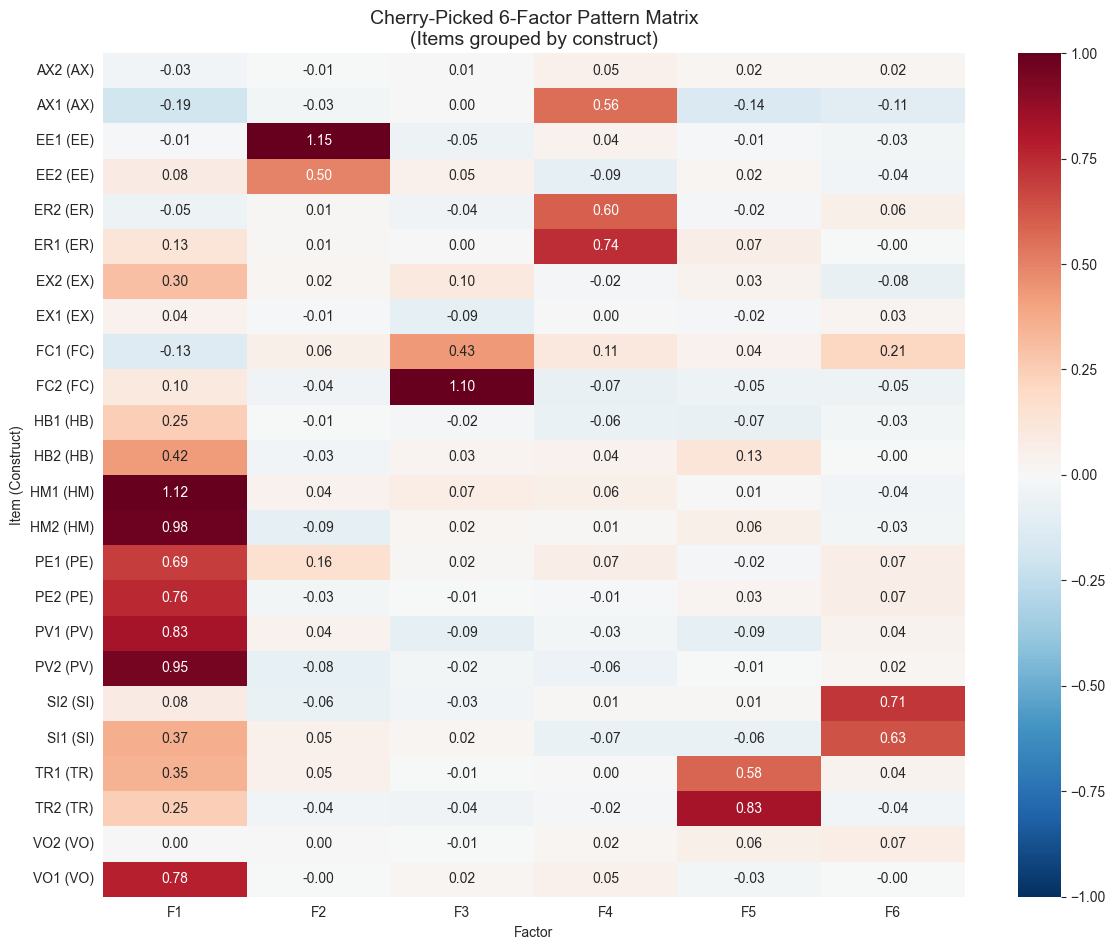

✓ Pattern matrix saved to plots/phase3_pattern_matrix.png


In [71]:
# Heatmap of selected factor loadings
plt.figure(figsize=(12, max(8, len(predictor_items) * 0.4)))

heatmap_data = selected_loadings[SELECTED_FACTORS].copy()

# Add construct grouping
heatmap_data['Construct'] = selected_loadings['Construct']
heatmap_data = heatmap_data.sort_values('Construct')

sns.heatmap(heatmap_data[SELECTED_FACTORS], 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1,
            yticklabels=[f"{idx} ({heatmap_data.loc[idx, 'Construct']})" for idx in heatmap_data.index])

plt.title(f'Cherry-Picked {len(SELECTED_FACTORS)}-Factor Pattern Matrix\n(Items grouped by construct)', fontsize=14)
plt.xlabel('Factor')
plt.ylabel('Item (Construct)')
plt.tight_layout()
plt.savefig('plots/phase3_pattern_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Pattern matrix saved to plots/phase3_pattern_matrix.png")

## 3.4 Factor Correlation Matrix

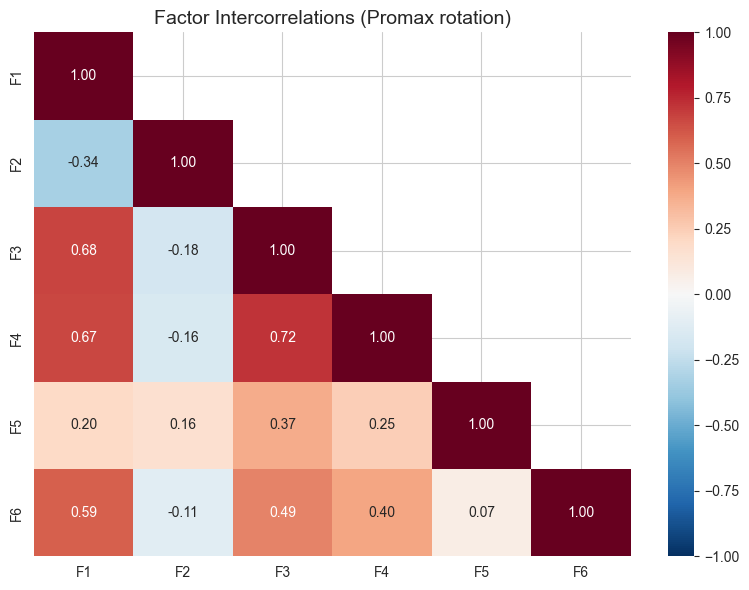

✓ Factor correlation matrix saved


In [72]:
# Factor correlations (from full solution, subset to selected)
if hasattr(efa_full, 'phi_'):
    factor_corr_full = pd.DataFrame(
        efa_full.phi_,
        index=[f'F{i+1}' for i in range(n_factors_max)],
        columns=[f'F{i+1}' for i in range(n_factors_max)]
    )
    factor_corr = factor_corr_full.loc[SELECTED_FACTORS, SELECTED_FACTORS]
    
    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(factor_corr, dtype=bool), k=1)
    sns.heatmap(factor_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
               vmin=-1, vmax=1, mask=mask)
    plt.title('Factor Intercorrelations (Promax rotation)', fontsize=14)
    plt.tight_layout()
    plt.savefig('plots/phase3_factor_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Factor correlation matrix saved")
else:
    print("Factor correlations not available (orthogonal rotation used)")

## 3.5 Export Results

In [73]:
# Export all results
print("=" * 90)
print("EXPORTING RESULTS")
print("=" * 90)

# 1. Pattern matrix
loadings_export = selected_loadings.copy()
loadings_export.to_csv('tables/pattern_matrix.csv')
print("✓ tables/pattern_matrix.csv")

# 2. Item assignments
assignment_df.to_csv('tables/item_assignments.csv', index=False)
print("✓ tables/item_assignments.csv")

# 3. Factor reliability
reliability_df.to_csv('tables/factor_reliability.csv', index=False)
print("✓ tables/factor_reliability.csv")

# 4. Item diagnostics
item_diag_df.to_csv('tables/item_diagnostics.csv', index=False)
print("✓ tables/item_diagnostics.csv")

# 5. Full loadings for reference
loadings_full.to_csv('tables/full_pattern_matrix.csv')
print("✓ tables/full_pattern_matrix.csv")

# 6. JSON summary
summary = {
    'population': POPULATION,
    'n_observations': len(df_full),
    'n_items_selected': len(predictor_items),
    'n_factors_selected': len(SELECTED_FACTORS),
    'selected_items': SELECTED_ITEMS,
    'selected_factors': SELECTED_FACTORS,
    'kmo': float(kmo_model),
    'bartlett_chi2': float(chi_square),
    'variance_explained': float(cum_var_full[len(SELECTED_FACTORS)-1]) if len(SELECTED_FACTORS) <= len(cum_var_full) else None
}

with open('tables/efa_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✓ tables/efa_summary.json")

EXPORTING RESULTS
✓ tables/pattern_matrix.csv
✓ tables/item_assignments.csv
✓ tables/factor_reliability.csv
✓ tables/item_diagnostics.csv
✓ tables/full_pattern_matrix.csv
✓ tables/efa_summary.json


## 3.6 APA Summary

In [74]:
# Generate APA-formatted summary
n_obs = len(df_full)
n_items = len(predictor_items)
n_factors_final = len(SELECTED_FACTORS)

# Calculate total variance for selected factors
total_var_selected = sum([eigenvalues_full[int(f[1:])-1] for f in SELECTED_FACTORS])
total_var_all = sum(eigenvalues_full)
var_pct = (total_var_selected / total_var_all) * 100 if total_var_all > 0 else 0

apa_summary = f"""
## APA-Formatted Method Summary

### Exploratory Factor Analysis - {POPULATION.title()} Sample

An exploratory factor analysis (EFA) was conducted on {n_items} predictor items using the 
full sample (*N* = {n_obs}). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was {kmo_model:.2f}, 
indicating {kmo_interpretation.lower()} factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²({n_items * (n_items - 1) // 2}) = {chi_square:.2f}, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method with oblique rotation (Promax). 
Initial parallel analysis suggested {n_factors_pa} factors, while the Kaiser criterion 
suggested {n_factors_kaiser} factors. After examining the full {n_factors_max}-factor solution, 
a {n_factors_final}-factor solution was selected based on loading quality, theoretical 
interpretability, and construct coherence.

The {n_factors_final}-factor solution explained approximately {var_pct:.1f}% of the extracted 
variance. Items were retained if they demonstrated a primary loading ≥ .40 on their assigned 
factor. Of the {n_items} items analyzed, {assigned_count} were assigned to factors with 
acceptable loadings.

### Factor Reliability

"""

# Add reliability info
for _, row in reliability_df.iterrows():
    if row['N_Items'] >= 2:
        apa_summary += f"- **{row['Factor']}** ({row['Primary_Construct']}): α = {row['Alpha']:.2f}, {row['N_Items']} items\n"
    else:
        apa_summary += f"- **{row['Factor']}** ({row['Primary_Construct']}): Single-item factor\n"

display(Markdown(apa_summary))


## APA-Formatted Method Summary

### Exploratory Factor Analysis - Full Sample

An exploratory factor analysis (EFA) was conducted on 24 predictor items using the 
full sample (*N* = 511). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was 0.95, 
indicating marvelous factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²(276) = 8589.47, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method with oblique rotation (Promax). 
Initial parallel analysis suggested 3 factors, while the Kaiser criterion 
suggested 4 factors. After examining the full 12-factor solution, 
a 6-factor solution was selected based on loading quality, theoretical 
interpretability, and construct coherence.

The 6-factor solution explained approximately 73.8% of the extracted 
variance. Items were retained if they demonstrated a primary loading ≥ .40 on their assigned 
factor. Of the 24 items analyzed, 19 were assigned to factors with 
acceptable loadings.

### Factor Reliability

- **F1** (HM): α = 0.94, 8 items
- **F2** (EE): α = 0.84, 2 items
- **F3** (FC): α = 0.78, 2 items
- **F4** (ER): α = 0.67, 3 items
- **F5** (TR): α = 0.91, 2 items
- **F6** (SI): α = 0.77, 2 items


## 3.7 Final Conclusions

In [75]:
# Final synthesis
conclusions = f"""
## Final Conclusions

### Model Summary
- **Sample**: {POPULATION.title()} (N = {n_obs})
- **Items Analyzed**: {n_items} (from {constructs_active} constructs)
- **Factors Retained**: {n_factors_final}
- **Items Assigned**: {assigned_count}/{n_items} ({assigned_count/n_items*100:.0f}%)

### Decision Point 1 Summary (Item Selection)
- Started with {len(ALL_PREDICTOR_ITEMS)} items across 12 constructs
- Selected {n_items} items from {constructs_active} constructs
- Constructs with full representation (2 items): {constructs_full}
- Constructs with partial representation (1 item): {constructs_partial}
- Constructs dropped: {constructs_dropped}

### Decision Point 2 Summary (Factor Selection)
- Maximum factors explored: {n_factors_max}
- Parallel analysis suggested: {n_factors_pa} factors
- Kaiser criterion suggested: {n_factors_kaiser} factors
- **Final selection**: {n_factors_final} factors ({', '.join(SELECTED_FACTORS)})

### Reliability Assessment
"""

good_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] >= 0.70)])
marginal_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] >= 0.60) & (reliability_df['Alpha'] < 0.70)])
poor_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] < 0.60)])
single_item = len(reliability_df[reliability_df['N_Items'] == 1])

conclusions += f"""
- Good reliability (α ≥ .70): {good_rel} factors
- Marginal reliability (.60 ≤ α < .70): {marginal_rel} factors
- Poor reliability (α < .60): {poor_rel} factors
- Single-item factors: {single_item}

### Recommendations
"""

if unassigned_count > 0:
    conclusions += f"- ⚠️ {unassigned_count} items did not load adequately on selected factors\n"
if poor_rel > 0:
    conclusions += f"- ⚠️ {poor_rel} factors have poor internal consistency\n"
if single_item > n_factors_final // 2:
    conclusions += f"- ⚠️ Many single-item factors - consider combining or re-evaluating\n"

conclusions += """
### Next Steps
1. Validate this structure with CFA on an independent sample
2. Consider theoretical justification for factor interpretations
3. Document any items that behave unexpectedly
"""

display(Markdown(conclusions))

print("\n" + "=" * 90)
print("✓ ANALYSIS COMPLETE")
print("=" * 90)


## Final Conclusions

### Model Summary
- **Sample**: Full (N = 511)
- **Items Analyzed**: 24 (from 12 constructs)
- **Factors Retained**: 6
- **Items Assigned**: 19/24 (79%)

### Decision Point 1 Summary (Item Selection)
- Started with 24 items across 12 constructs
- Selected 24 items from 12 constructs
- Constructs with full representation (2 items): 12
- Constructs with partial representation (1 item): 0
- Constructs dropped: 0

### Decision Point 2 Summary (Factor Selection)
- Maximum factors explored: 12
- Parallel analysis suggested: 3 factors
- Kaiser criterion suggested: 4 factors
- **Final selection**: 6 factors (F1, F2, F3, F4, F5, F6)

### Reliability Assessment

- Good reliability (α ≥ .70): 5 factors
- Marginal reliability (.60 ≤ α < .70): 1 factors
- Poor reliability (α < .60): 0 factors
- Single-item factors: 0

### Recommendations
- ⚠️ 5 items did not load adequately on selected factors

### Next Steps
1. Validate this structure with CFA on an independent sample
2. Consider theoretical justification for factor interpretations
3. Document any items that behave unexpectedly



✓ ANALYSIS COMPLETE


In [76]:
# Final synthesis
conclusions = f"""
## Final Conclusions

### Model Summary
- **Sample**: {POPULATION.title()} (N = {n_obs})
- **Items Analyzed**: {n_items} (from {constructs_active} constructs)
- **Factors Retained**: {n_factors_final}
- **Items Assigned**: {assigned_count}/{n_items} ({assigned_count/n_items*100:.0f}%)

### Decision Point 1 Summary (Item Selection)
- Started with {len(ALL_PREDICTOR_ITEMS)} items across 12 constructs
- Selected {n_items} items from {constructs_active} constructs
- Constructs with full representation (2 items): {constructs_full}
- Constructs with partial representation (1 item): {constructs_partial}
- Constructs dropped: {constructs_dropped}

### Decision Point 2 Summary (Factor Selection)
- Maximum factors explored: {n_factors_max}
- Parallel analysis suggested: {n_factors_pa} factors
- Kaiser criterion suggested: {n_factors_kaiser} factors
- **Final selection**: {n_factors_final} factors ({', '.join(SELECTED_FACTORS)})

### Reliability Assessment
"""

good_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] >= 0.70)])
marginal_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] >= 0.60) & (reliability_df['Alpha'] < 0.70)])
poor_rel = len(reliability_df[(reliability_df['N_Items'] >= 2) & (reliability_df['Alpha'] < 0.60)])
single_item = len(reliability_df[reliability_df['N_Items'] == 1])

conclusions += f"""
- Good reliability (α ≥ .70): {good_rel} factors
- Marginal reliability (.60 ≤ α < .70): {marginal_rel} factors
- Poor reliability (α < .60): {poor_rel} factors
- Single-item factors: {single_item}

### Recommendations
"""

if unassigned_count > 0:
    conclusions += f"- ⚠️ {unassigned_count} items did not load adequately on selected factors\n"
if poor_rel > 0:
    conclusions += f"- ⚠️ {poor_rel} factors have poor internal consistency\n"
if single_item > n_factors_final // 2:
    conclusions += f"- ⚠️ Many single-item factors - consider combining or re-evaluating\n"

conclusions += """
### Next Steps
1. Validate this structure with CFA on an independent sample
2. Consider theoretical justification for factor interpretations
3. Document any items that behave unexpectedly
"""

display(Markdown(conclusions))

print("\n" + "=" * 90)
print("✓ ANALYSIS COMPLETE")
print("=" * 90)


## Final Conclusions

### Model Summary
- **Sample**: Full (N = 511)
- **Items Analyzed**: 24 (from 12 constructs)
- **Factors Retained**: 6
- **Items Assigned**: 19/24 (79%)

### Decision Point 1 Summary (Item Selection)
- Started with 24 items across 12 constructs
- Selected 24 items from 12 constructs
- Constructs with full representation (2 items): 12
- Constructs with partial representation (1 item): 0
- Constructs dropped: 0

### Decision Point 2 Summary (Factor Selection)
- Maximum factors explored: 12
- Parallel analysis suggested: 3 factors
- Kaiser criterion suggested: 4 factors
- **Final selection**: 6 factors (F1, F2, F3, F4, F5, F6)

### Reliability Assessment

- Good reliability (α ≥ .70): 5 factors
- Marginal reliability (.60 ≤ α < .70): 1 factors
- Poor reliability (α < .60): 0 factors
- Single-item factors: 0

### Recommendations
- ⚠️ 5 items did not load adequately on selected factors

### Next Steps
1. Validate this structure with CFA on an independent sample
2. Consider theoretical justification for factor interpretations
3. Document any items that behave unexpectedly



✓ ANALYSIS COMPLETE
